In [1]:
import numpy as np 
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Load data

In [2]:
digits = load_digits()
features = digits.data
labels = digits.target
print(f"Feauters -> type:{type(features)}; shape:{features.shape}")
print(f"Labels   -> type:{type(labels)}; shape:{labels.shape}")

Feauters -> type:<class 'numpy.ndarray'>; shape:(1797, 64)
Labels   -> type:<class 'numpy.ndarray'>; shape:(1797,)


In [3]:
print(labels[:10])

[0 1 2 3 4 5 6 7 8 9]


# PCA 

In [4]:
# sample average
mu = np.mean(features, axis=0)
print(f"Shape of mean:{mu.shape}")

# mean centered sample
X = features - mu
# print(np.mean(X, axis=0))

Shape of mean:(64,)


In [5]:
# the covariance matrix
A = np.cov(X, rowvar=False)
print(f"shape of covariance matrix:{A.shape}")
# eigenvalues and right eigenvectors
eig_value, eig_vect = np.linalg.eig(A)

shape of covariance matrix:(64, 64)


In [6]:
print(f"eigenValues: {eig_value.shape}; type: {type(eig_value)}")
print(f"eigenValues: {eig_vect.shape}; type: {type(eig_vect)}")

eigenValues: (64,); type: <class 'numpy.ndarray'>
eigenValues: (64, 64); type: <class 'numpy.ndarray'>


In [7]:
# find the value of K for which 95% of energy is retained
k = 1
energy = 0
while energy <= 0.95:
    eig_value_k = eig_value[:k]
    energy = eig_value_k.sum()/eig_value.sum()
    k += 1
#     print(energy)
print(f"k:{k} -> energy:{energy}")

k:30 -> energy:0.9547965245651596


In [8]:
# choose the first k eigen vectors
U_k = eig_vect[:, :k]
print(f"shape of projection matrix: {U_k.shape}")

shape of projection matrix: (64, 30)


In [9]:
# Projection
X_proj = X.dot(U_k)
print(f"projected matrix shape: {X_proj.shape}")

projected matrix shape: (1797, 30)


# K-means clustering

In [10]:
def compute_cost(X, centroids, cluster):
    m = X.shape[0]
    sum = 0
    for i in range(m):
        sum += (X[i] - centroids[int(cluster[i])]) @ (X[i] - centroids[int(cluster[i])]).T
    cost = sum/m
    return cost

In [11]:
def my_kmeans(X, k, seed=41):
    diff = 1
    np.random.seed(seed)
    cluster_labels = np.zeros(X.shape[0]) #cluster label for each sample
    rand_idx = np.random.choice(len(X), k, replace=False)
    #Randomly choosing Centroids 
    centroids = X[rand_idx, :] #Step 1 
    
    while diff:
        for i, row in enumerate(X):
            min_dist = float('inf')
            for idx, centroid in enumerate(centroids):
                d = np.sqrt((row - centroid) @ (row-centroid).T)
                if min_dist > d:
                    min_dist = d
                    cluster_labels[i] = idx
        new_centroids = pd.DataFrame(X).groupby(by=cluster_labels).mean().values
        
        if np.count_nonzero(centroids-new_centroids) == 0:
            diff = 0
        else:
            centroids = new_centroids
    cost = compute_cost(X, centroids, cluster_labels)
    cal_score = calinski_harabasz_score(X, cluster_labels)
    return centroids, cluster_labels, cost, cal_score

# With PCA

## Variation wrt No of Clusters

In [12]:
def plot_cost(cost, k):
    plt.plot(range(2, k), cost)
    plt.show()

k=2 -> cost:1022.846; calinski:227.217; sil:0.113
k=3 -> cost:914.029; calinski:233.853; sil:0.132
k=4 -> cost:848.284; calinski:214.212; sil:0.135
k=5 -> cost:793.839; calinski:202.308; sil:0.147
k=6 -> cost:758.399; calinski:186.053; sil:0.152
k=7 -> cost:696.494; calinski:195.247; sil:0.172
k=8 -> cost:675.095; calinski:180.664; sil:0.160
k=9 -> cost:640.197; calinski:178.788; sil:0.174
k=10 -> cost:599.847; calinski:182.874; sil:0.194
k=11 -> cost:590.265; calinski:170.065; sil:0.179
k=12 -> cost:576.832; calinski:161.895; sil:0.177
k=13 -> cost:558.276; calinski:158.192; sil:0.177
k=14 -> cost:546.042; calinski:152.284; sil:0.179


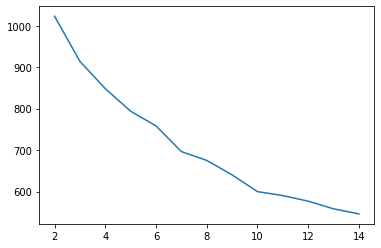

In [13]:
K = 15
cost = np.zeros(K-2)
sil_score = np.zeros(K-2)
cal_score = np.zeros(K-2)
centroids_lst = []
labels = np.zeros((K-1, X.shape[0]))

for k in range(2, K):
    centroids, labels[k-2], cost[k-2], cal_score[k-2] = my_kmeans(X_proj, k)
    centroids_lst.append(centroids)
    sil_score[k-2] = silhouette_score(X_proj, labels[k-2])
    print(f"k={k} -> cost:{cost[k-2]:.3f}; calinski:{cal_score[k-2]:.3f}; sil:{sil_score[k-2]:.3f}")

# print(f"silhouette_score:{sil_score}\nCost: {cost}\ncalinski_harabasz_score: {cal_score}")
plot_cost(cost, K)

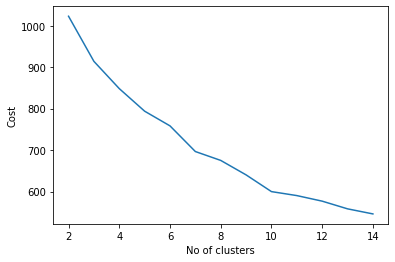

In [14]:
plt.figure()
plt.plot(range(2, K), cost)
plt.savefig("pca_cost_vs_clusters.png")
plt.xlabel("No of clusters")
plt.ylabel("Cost")
plt.show()

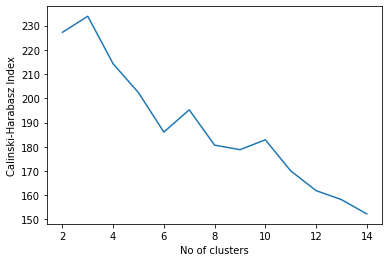

In [15]:
plt.figure()
plt.plot(range(2, K), cal_score)
plt.xlabel("No of clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.savefig("pca_cal_score_vs_clusters.png")
plt.show()

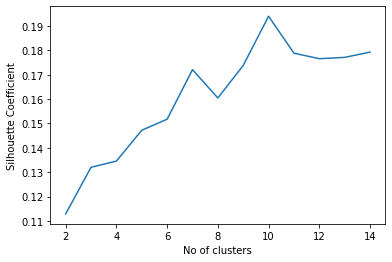

In [16]:
plt.figure()
plt.plot(range(2, K), sil_score)
plt.xlabel("No of clusters")
plt.ylabel("Silhouette Coefficient")
plt.savefig("pca_cost_vs_sil_score.png")
plt.show()

## Variation wrt No of Samples

j=0.10 -> cost:594.816; calinski:17.635; sil:0.154
j=0.20 -> cost:626.488; calinski:32.606; sil:0.165
j=0.30 -> cost:607.669; calinski:52.928; sil:0.181
j=0.40 -> cost:651.797; calinski:61.314; sil:0.158
j=0.50 -> cost:599.290; calinski:92.265; sil:0.198
j=0.60 -> cost:610.063; calinski:106.227; sil:0.186
j=0.70 -> cost:609.759; calinski:124.000; sil:0.192
j=0.80 -> cost:615.841; calinski:138.900; sil:0.170
j=0.90 -> cost:609.277; calinski:159.183; sil:0.197
j=1.00 -> cost:599.810; calinski:182.898; sil:0.194


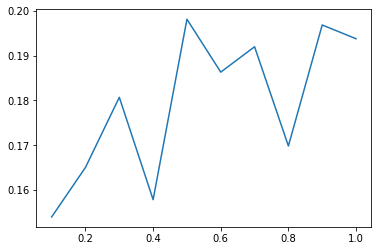

In [17]:
ki = 10
per = np.linspace(0.1, 1, num=10)
z = per.shape[0]
cost_sam = np.zeros(z)
sil_score_sam = np.zeros(z)
cal_score_sam = np.zeros(z)
centroids_lst_sam = []
labels_lst_sam = []
for i, j in enumerate(per):
    idx = np.random.choice(range(X_proj.shape[0]), int(j*X_proj.shape[0]), replace=False)
    X_per = X_proj[idx,:]
#     print(i, j, X_per.shape[0])
    centroids_sam, labels_sam, cost_sam[i], cal_score_sam[i] = my_kmeans(X_per, ki)
    centroids_lst_sam.append(centroids_sam)
    labels_lst_sam.append(labels_sam)
    sil_score_sam[i] = silhouette_score(X_per, labels_lst_sam[i])
    print(f"j={j:.2f} -> cost:{cost_sam[i]:.3f}; calinski:{cal_score_sam[i]:.3f}; sil:{sil_score_sam[i]:.3f}")

plt.plot(per, sil_score_sam)

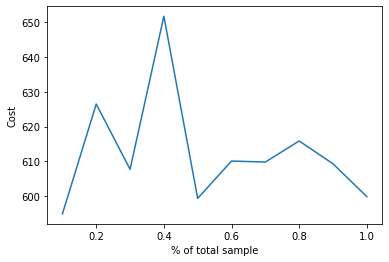

In [18]:
plt.figure()
plt.plot(per, cost_sam)
plt.savefig("pca_cost_vs_per_sample.png")
plt.xlabel("% of total sample")
plt.ylabel("Cost")
plt.show()

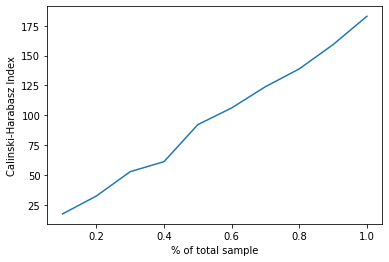

In [19]:
plt.figure()
plt.plot(per, cal_score_sam)
plt.savefig("pca_cal_vs_per_sample.png")
plt.xlabel("% of total sample")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

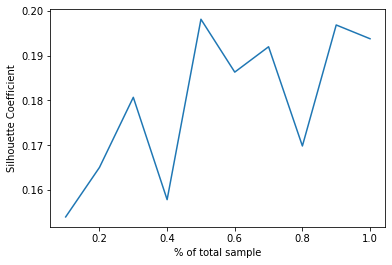

In [20]:
plt.figure()
plt.plot(per, sil_score_sam)
plt.savefig("pca_sim_vs_per_sample.png")
plt.xlabel("% of total sample")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Different Initialization

In [21]:
seeds = [21, 75, 84, 12, 51]
ls = len(seeds)
cost_in = np.zeros(ls)
cal_in = np.zeros(ls)
sil_in = np.zeros(ls)
for ij, seed in enumerate(seeds):
    labels_in, cost_in[ij], cal_in[ij] = my_kmeans(X_proj, 10, seed=seed)[1:4]
    sil_in[ij] = silhouette_score(X_proj, labels_in)
    print(f"seed: {seed} -> cost:{cost_in[ij]:.3f}; cal:{cal_in[ij]:.3f}; sil:{sil_in[ij]:.3f}")

seed: 21 -> cost:603.331; cal:180.672; sil:0.195
seed: 75 -> cost:619.554; cal:170.742; sil:0.182
seed: 84 -> cost:643.371; cal:157.071; sil:0.160
seed: 12 -> cost:624.812; cal:167.634; sil:0.179
seed: 51 -> cost:602.507; cal:181.190; sil:0.198


# Without PCA

## Variation wrt No of Clusters

k=2 -> cost:1071.9844924939644; calinski:216.83351873725192; sil:0.10805693446770007
k=3 -> cost:963.1397562512182; calinski:221.97200839164736; sil:0.12594007980873465
k=4 -> cost:897.3254538344669; calinski:202.58232767742942; sil:0.12823815120005538
k=5 -> cost:842.835205271939; calinski:190.63311709290048; sil:0.13979644310009834
k=6 -> cost:807.3477236850883; calinski:174.8660768558244; sil:0.14424120417866435
k=7 -> cost:763.2294029124942; calinski:171.30417706484843; sil:0.14038248734744196
k=8 -> cost:723.8563136294713; calinski:168.6338059817098; sil:0.15064571021755507
k=9 -> cost:688.8895294531362; calinski:166.30197305903795; sil:0.16349684366629763
k=10 -> cost:650.4929981195207; calinski:168.18210169035555; sil:0.17961557236891865
k=11 -> cost:640.793944153933; calinski:156.27223849514968; sil:0.16454288578649362
k=12 -> cost:625.241229966015; calinski:149.55448777293125; sil:0.16545270070601284
k=13 -> cost:606.563304437686; calinski:145.81181175062738; sil:0.16616052275

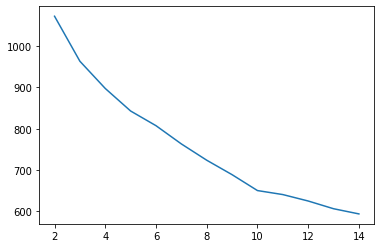

In [22]:
K_w = 15
cost_w = np.zeros(K_w-2)
sil_score_w = np.zeros(K_w-2)
cal_score_w = np.zeros(K_w-2)
centroids_lst_w = []
labels_w = np.zeros((K_w-1, X.shape[0]))

for k in range(2, K_w):
    centroids_w, labels_w[k-2], cost_w[k-2], cal_score_w[k-2] = my_kmeans(X, k)
    centroids_lst_w.append(centroids_w)
    sil_score_w[k-2] = silhouette_score(X, labels_w[k-2])
    print(f"k={k} -> cost:{cost_w[k-2]}; calinski:{cal_score_w[k-2]}; sil:{sil_score_w[k-2]}")

# print(f"silhouette_score:{sil_score}\nCost: {cost}\ncalinski_harabasz_score: {cal_score}")
plot_cost(cost_w, K)

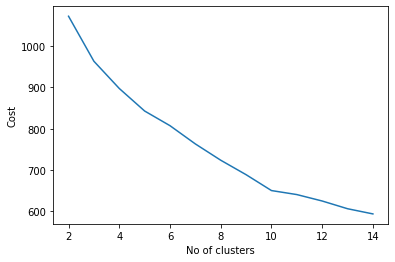

In [23]:
plt.figure()
plt.plot(range(2, K_w), cost_w)
plt.savefig("no_pca_cost_vs_clusters.png")
plt.xlabel("No of clusters")
plt.ylabel("Cost")
plt.show()

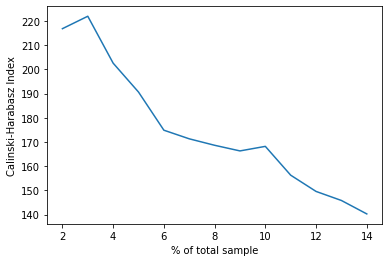

In [24]:
plt.figure()
plt.plot(range(2, K_w), cal_score_w)
plt.savefig("no_pca_cal_vs_clusters.png")
plt.xlabel("% of total sample")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

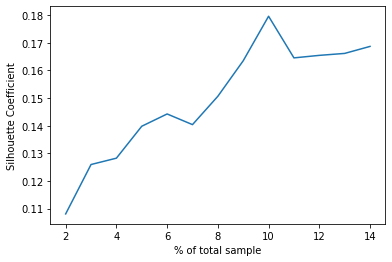

In [25]:
plt.figure()
plt.plot(range(2, K_w), sil_score_w)
plt.savefig("no_pca_sil_vs_clusters.png")
plt.xlabel("% of total sample")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Variation wrt No of Samples

j=0.10 -> cost:642.694; calinski:16.411; sil:0.145
j=0.20 -> cost:674.610; calinski:30.290; sil:0.155
j=0.30 -> cost:653.539; calinski:49.470; sil:0.171
j=0.40 -> cost:687.670; calinski:59.704; sil:0.164
j=0.50 -> cost:647.867; calinski:85.482; sil:0.187
j=0.60 -> cost:657.766; calinski:98.715; sil:0.173
j=0.70 -> cost:655.380; calinski:116.029; sil:0.185
j=0.80 -> cost:664.052; calinski:128.964; sil:0.159
j=0.90 -> cost:679.440; calinski:137.189; sil:0.162
j=1.00 -> cost:648.405; calinski:169.363; sil:0.182


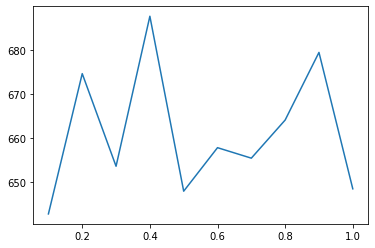

In [26]:
ki_w = 10
per_w = np.linspace(0.1, 1, num=10)
z_w = per_w.shape[0]
cost_sam_w = np.zeros(z_w)
sil_score_sam_w = np.zeros(z_w)
cal_score_sam_w = np.zeros(z_w)
centroids_lst_sam_w = []
labels_lst_sam_w = []
for i, j in enumerate(per_w):
    idx_w = np.random.choice(range(X.shape[0]), int(j*X.shape[0]), replace=False)
    X_per_w = X[idx_w,:]
#     print(i, j, X_per.shape[0])
    centroids_sam_w, labels_sam_w, cost_sam_w[i], cal_score_sam_w[i] = my_kmeans(X_per_w, ki_w)
    centroids_lst_sam_w.append(centroids_sam_w)
    labels_lst_sam_w.append(labels_sam_w)
    sil_score_sam_w[i] = silhouette_score(X_per_w, labels_lst_sam_w[i])
    print(f"j={j:.2f} -> cost:{cost_sam_w[i]:.3f}; calinski:{cal_score_sam_w[i]:.3f}; sil:{sil_score_sam_w[i]:.3f}")

plt.plot(per_w, cost_sam_w)
plt.show()

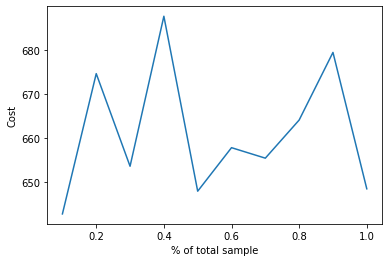

In [27]:
plt.figure()
plt.plot(per_w, cost_sam_w)
plt.savefig("no_pca_cost_vs_per_sample.png")
plt.xlabel("% of total sample")
plt.ylabel("Cost")
plt.show()

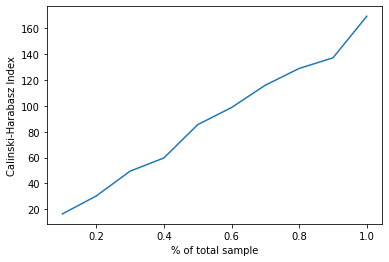

In [28]:
plt.figure()
plt.plot(per_w, cal_score_sam_w)
plt.savefig("no_pca_cal_vs_per_sample.png")
plt.xlabel("% of total sample")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

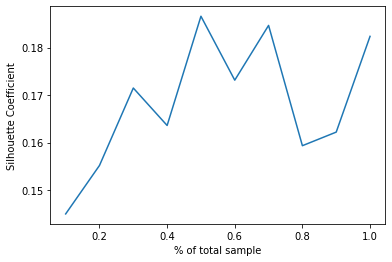

In [29]:
plt.figure()
plt.plot(per_w, sil_score_sam_w)
plt.savefig("no_pca_sil_vs_per_sample.png")
plt.xlabel("% of total sample")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Different Initialization

In [30]:
seeds_w = [48, 14, 97, 62, 53]
ls_w = len(seeds_w)
cost_in_w = np.zeros(ls_w)
cal_in_w = np.zeros(ls_w)
sil_in_w = np.zeros(ls_w)
for ij, seed in enumerate(seeds_w):
    labels_in_w, cost_in_w[ij], cal_in_w[ij] = my_kmeans(X, 10, seed=seed)[1:4]
    sil_in_w[ij] = silhouette_score(X, labels_in_w)
    print(f"seed: {seed} -> cost:{cost_in_w[ij]:.3f}; cal:{cal_in_w[ij]:.3f}; sil:{sil_in_w[ij]:.3f}")

seed: 48 -> cost:650.183; cal:168.357; sil:0.188
seed: 14 -> cost:650.176; cal:168.361; sil:0.188
seed: 97 -> cost:682.802; cal:150.829; sil:0.163
seed: 62 -> cost:650.852; cal:167.980; sil:0.187
seed: 53 -> cost:659.397; cal:163.230; sil:0.173
